> First of first, please run the below code box to install required packages

!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install statsmodels
!pip install torch

# Overview of the Notebook
---
This notebook contains the whole code to make sliding-window based prediction of the paper: 

> CESNET-TimeSeries24: Time Series Dataset for Network Traffic Anomaly Detection and Forecasting

It has 5 major steps in 5 code cell:
- Step 1: load the data and pre-processing (e.g.fill the missing values)
- Step 2: Define the evaluation metric: Global RMSE
- Step 3: Define the LSTMModel
- Step 4: Train the models and prediction on sliding window
- Step 5: visulization of the prediction results
- Appendix: test code for long sliding window v.s. sliding window on the last prediction

Run the below code cells in sequential to avoid dependence issue 

## **Step 1: load the data and pre-processing (e.g.fill the missing values)**

- The data used here is from "./data/103.csv", which is the 'n_flows' on a single IP 103
- The attribute used here is the 'n_flows', which the number of flows on the IP 103
- At the end, it re-produce the Figure 10 in the paper. It helps to have a visual inspect the shape of the data.

Note: This step learn the code from the example provided by the paper


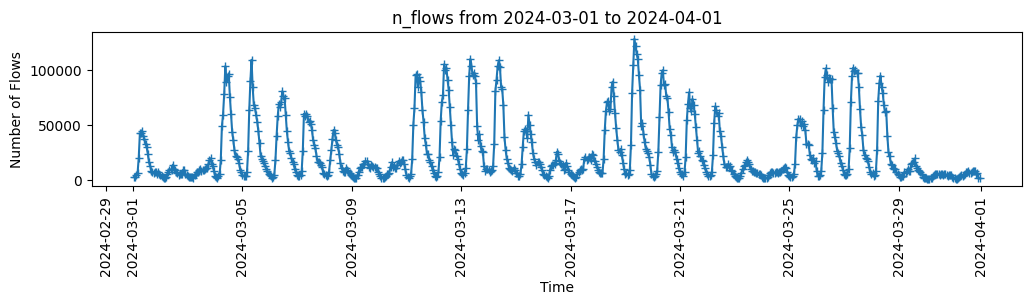

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

## re-use the function from the paper's example code
def fill_missing(train_df, train_time_ids):
    df_missing = pd.DataFrame(columns=train_df.columns)
    df_missing.id_time = train_time_ids[~train_time_ids.isin(train_df.id_time)].values
    for column in train_df.columns:
        if column == "id_time":
            continue
        if column in ["tcp_udp_ratio_packets","tcp_udp_ratio_bytes","dir_ratio_packets","dir_ratio_bytes"]:
            df_missing[column] = 0.5
        else:
            df_missing[column] = 0 # train_df[column].mean()
    return pd.concat([train_df, df_missing]).sort_values(by="id_time").reset_index()[train_df.columns]


##Load the time
df = pd.read_csv("./data/103.csv")

## Load the time file
df_times = pd.read_csv("./data/times_1_hour.csv")
df_times['time'] = pd.to_datetime(df_times['time'])
##display(df_times.head(2))

## fill the miss value: resue the code from example of the paper
df = fill_missing(df, df_times.id_time)
df['time'] = df_times['time']
df = df[['time'] + df.keys().drop('time').to_list()]
df['time'] = pd.to_datetime(df['time'])
##display(df.head(2))



# Plotting 'n_flows' over time, Fig.10 in the paper
# This serves the purpose to to have visual effect of the data to predict
start_date = '2024-03-01'
end_date = '2024-04-01'
mask = (df['time'] > start_date) & (df['time'] < end_date)
df_filtered = df.loc[mask]
plt.figure(figsize=(12, 2))
plt.plot(df_filtered['time'], df_filtered['n_flows'], marker='+')
plt.title('n_flows from 2024-03-01 to 2024-04-01')
plt.xlabel('Time')
plt.ylabel('Number of Flows')
plt.xticks(rotation=90)
plt.show()


## **Step 2: Define the evaluation metric: Global RMSE**

Root Mean Squared Error (RMSE)  is defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value

Global Root Mean Squared Error means that we will compute the RMSE for the while  time series instead of for each window. It gives us the big picture of the overall performance of each window.

At the end, it also defines a function evaluate_cost to calculate the average time of each training/prediction.

In [2]:
from sklearn.metrics import root_mean_squared_error

def evaluate_rmse(df, model_predictions, metric, time_index_min, time_index_max):
    """
    Evaluates model predictions using a specified metric on a subset of the data,
    defined by the training period and a maximum time index.

    Parameters:
    ----------
    df : pandas.DataFrame
        The original dataset containing the actual target values and time-based indexing.

    model_predictions : dict, "method name" : list of prediction value
        The model's predicted values, indexed by time to match the target data.
        Must support .loc indexing with the same time index as df.

    metric : string
        'n_flows' in this case, the column name in df to predict

    time_index_min : int
        The minimum time index starting which evaluation should be done. 
        In global RMSE, it is the number of initial time steps used for training.
        In locaal RMSE, it is the first index to predict
        
    time_index_max : int
        The maximum time index up to which evaluation should be done. Used to define the end of the test/evaluation window.
    """
    for method_name in model_predictions:
        predictions = model_predictions[method_name]
        tmp = df[(df.id_time >= time_index_min - 1) & (df.id_time < time_index_max)]
        y_true = tmp[metric].values
        y_pred = predictions[:len(y_true)]    
        rmse = root_mean_squared_error(y_true, y_pred)
    
        print(f"{method_name} predictions length = {len(predictions)}")
        print(f"{method_name}     RMSE: {rmse:.4f}")

def evaluate_cost(train_model_cost, predict_model_cost):
    """
    Evaluates and prints the average training and prediction time cost for each model.
    - If a model has no recorded times, the average is set to 0.0.
    - If a model is missing from predict_model_cost, prediction average is also set to 0.0.

    Parameters:
    train_model_cost: dict, "method name" : list of time to training model  

    predict_model_cost: dict, "method name" : list of time to perdict  
    """
    for method_name in train_model_cost:
        train_cost = train_model_cost[method_name]
        predict_cost = predict_model_cost[method_name]

        # Compute averages safely
        train_cost_ave = sum(train_cost) / len(train_cost) if train_cost else 0.0
        predict_cost_ave = sum(predict_cost) / len(predict_cost) if predict_cost else 0.0

        print(f"{method_name}: train_cost={train_cost_ave:.4f}, predict_cost={predict_cost_ave:.4f}")


## **Step 3: Define the LSTMModel**

This code cell defines the LSTM model.
It has two functions, LSTMModel and LSTMWrapper
- LSTMModel: defines the architecture of LSTM model
- LSTMWrapper: have a function to train and predict the data with LSTMModel

This implemtation use the pre-built nn.LSTM from the torch.nn https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html

<img src="figure/lstm.png" alt="LSTM" width="400" height="300"/>

LSTM inside (I use the implementaion of torch.nn.LSTM):

<img src="figure/lstm-inside.png" alt="LSTM" width="400" height="300"/>

An examplation of the LSTM can be found
https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random

# Set all random seeds to have (hopefully) have same result
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

##Define the structure of the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_features=1, hidden_size=128, num_layers=2, output_size=1, dropout=0.2):
        """
        intilize the model

        Parameters:
        n_features: int
            number of feature (in our case, we only have 1 variable, n_flow)

        hidden_size: int
            number of hiden LSTM cell

        num_layers: int
            number of LSTM layers

        output_size: int
            the size of final predict

        dropout: float
            control the percentage of hiden paramters in trainning
        """
        super(LSTMModel, self).__init__()
        self.num_layers=num_layers
        self.hidden_size = hidden_size
        # have LSTM from pytorch
        self.lstm = nn.LSTM(
            n_features, hidden_size, num_layers,
            dropout=dropout, batch_first=True
        )
        # have a Fully connected output layer at the end: from 128 to 1 
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        define the forward step in the model
        
        Parameters:
        x: tensor
        the input data 

        """
        #intialize the h0 and c0
        # h0: hiden layer output, short term impact
        # c0: cell state, long term impact
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        ## The second item is not needed. it a tuple of the final hidden and cell states:
        ## x has the size: batch, time, feature
        out, _ = self.lstm(x, (h0, c0))
        ## -1 – last time step in the sequence
        ## first : all batches ; second : all all hidden units (hidden_size)
        return self.linear(out[:, -1, :])  # Take last time step's output

class LSTMWrapper:
    def __init__(self, train_data, seq_len=48, hidden_size=128, num_layers=2,
                 dropout=0.2, epochs=50, lr=0.001, batch_size=32):
        """
        Build the model:
        - intilize the MinMaxScaler and the LSTMModel
        - call the fit function to train the model

        Parameters:
        train_data: numpy array
            input data to train the model

        seq_len: int
            the size of input series to predict (per time)
            
        hidden_size: int
            number of hiden LSTM cell

        num_layers: int
            number of LSTM layers

        output_size: int
            the size of final predict
    
        dropout: float
            control the percentage of hiden paramters in trainning

        epochs: int
            number of pass to train over whole data

        lr: float
            learning rate in optimization

        batch_size:
            the size of each batch in training
        """
        self.seq_len = seq_len
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.scaler = MinMaxScaler()
        self.model = LSTMModel(n_features=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1, dropout=dropout)
        self._fit(train_data)

    def _fit(self, train_data):
        """
        Core algorithm of training:
        - 1, normalize the data with min/max value
        - 2, build the sliwding window with seq_len
        - 3, build a DataLoader to load data in batch
        - 4, train the model with epochs and batch
        """
        # Normalize data to between (0,1),  (x-min)/(max-min)
        ## https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
        scaled = self.scaler.fit_transform(np.array(train_data).reshape(-1, 1)).flatten()

        # Create sliding window sequences
        X, y = [], []
        for i in range(len(scaled) - self.seq_len):
            X.append(scaled[i:i + self.seq_len])
            y.append(scaled[i + self.seq_len])
        X = torch.tensor(X).float().unsqueeze(-1)
        y = torch.tensor(y).float().unsqueeze(-1)

        # create a dataset object from pytorch for DataLoader, which help load data in batch and also help with shuffle
        dataset = TensorDataset(X, y)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Training
        ## optim functions, other options torch.optim.SGD (Stochastic Gradient Descent)
        ## The Adam: Adaptive Moment Estimation
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)
        loss_fn = nn.MSELoss()
        self.model.train() ## enable dropout 
        for epoch in range(self.epochs):
            epoch_loss = 0
            for xb, yb in loader:
                optimizer.zero_grad() # Clear old gradients
                pred = self.model(xb) # Forward pass
                loss = loss_fn(pred, yb)
                loss.backward() # Compute new gradients (Backward)
                optimizer.step() # Update weights
                epoch_loss += loss.item()
            # if epoch%10 == 0:
            #     print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss / len(loader):.6f}")

        self.last_input = scaled[-self.seq_len:]  # save last input for forecasting

    def forecast(self, steps):
        """
        Forcast the data in next steps

        Parameters:
        steps: int
            the number of steps in future to predict
        """
        self.model.eval() ## disable dropout
        input_seq = self.last_input.copy()
        preds = []
        for _ in range(steps):
            ## add batch dimension (0) and feature dimension (-1) to match input of x in forward
            inp = torch.tensor(input_seq[-self.seq_len:]).float().unsqueeze(0).unsqueeze(-1)
            with torch.no_grad():
                pred = self.model(inp).item()
            preds.append(pred)
            input_seq = np.append(input_seq, pred)
        return self.scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()



## **Step 5: Train the models and prediction on sliding window** 

This code cells contains the code to train the LSTM as well as existing SARIMA model. 
It has below default setting and can be adjusted for different tests:
- TRAINING_PERIOD = 744, it says 31 Days as training data
- TESTING_PERIOD = 168, it says to predict 7 Days
- TS_METRIC = 'n_flows', it says the attribute to predict
- time_index_max= TRAINING_PERIOD+1*TESTING_PERIOD
  the **time_index_max** says the how far we test. it is mostly for testing purpose, since I don't want to run the whole period all time.
  One can set **time_index_max=df.id_time.max()** to test all 

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import time

TRAINING_PERIOD = 744  #31 Days
TESTING_PERIOD = 168   #7 Days
TS_METRIC = 'n_flows'

time_index_max=df.id_time.max() #df.id_time.max() = 6717
##time_index_max=TRAINING_PERIOD+1*TESTING_PERIOD

print(f"df.id_time.max() = {df.id_time.max()}")
print(f"TRAINING_PERIOD = {TRAINING_PERIOD}")
print(f"TESTING_PERIOD = {TESTING_PERIOD}")
print(f"time_index_max = {time_index_max}")

model_to_evaluate=["LSTM"]
model_predictions = {model: [] for model in model_to_evaluate}
model_cost_train = {model: [] for model in model_to_evaluate}
model_cost_predict = {model: [] for model in model_to_evaluate}

tmp_index = 0
while tmp_index <= time_index_max - TRAINING_PERIOD:
    all_start_time = time.time()
    train_df = df[df.id_time < tmp_index + TRAINING_PERIOD] #744
    train_df = train_df[train_df.id_time >= tmp_index] # 0 - 744
    train_data = train_df[TS_METRIC].to_numpy()

    predict_start_index = tmp_index + TRAINING_PERIOD
    # Fit and predict with SARIMA
    if "SARIMA" in model_to_evaluate:
        start_time = time.time()
        ORDER = (1, 1, 1)
        SEASONAL_ORDER = (1, 1, 1, 168)
        model = SARIMAX(train_data, order=ORDER, seasonal_order=SEASONAL_ORDER)
        results = model.fit(disp=False)
        model_cost_train["SARIMA"].append(time.time() - start_time)
        #print(f"SARIMA train time = {time.time() - start_time}")
        
        start_time = time.time()
        preds = list(results.forecast(steps=TESTING_PERIOD))
        model_predictions["SARIMA"] += preds 
        model_cost_predict["SARIMA"].append(time.time() - start_time)


    # Fit and predict with LSTM
    if "LSTM" in model_to_evaluate:
        start_time = time.time()
        lstm_model = LSTMWrapper(
        train_data, 
        seq_len=168, 
        hidden_size=168, 
        num_layers=2, 
        dropout=0.2, 
        epochs=60, 
        lr=0.001,
        batch_size=8
        )
        model_cost_train["LSTM"].append(time.time() - start_time)
        #print(f"LSTM train time = {time.time() - start_time}")

        start_time = time.time()
        preds = list(lstm_model.forecast(steps=TESTING_PERIOD))
        model_predictions["LSTM"] += preds 
        model_cost_predict["LSTM"].append(time.time() - start_time)

    tmp_index += TESTING_PERIOD
    print(f"tmp_index = {tmp_index}, time={time.time() - all_start_time}")


evaluate_rmse(df, model_predictions, TS_METRIC, TRAINING_PERIOD, time_index_max)

evaluate_cost(model_cost_train, model_cost_predict)

df.id_time.max() = 6717
TRAINING_PERIOD = 744
TESTING_PERIOD = 168
time_index_max = 6717
tmp_index = 168, time=216.13214492797852
tmp_index = 336, time=205.43894696235657
tmp_index = 504, time=220.43374300003052
tmp_index = 672, time=209.77404499053955
tmp_index = 840, time=223.30777406692505
tmp_index = 1008, time=221.41074800491333
tmp_index = 1176, time=207.3639039993286
tmp_index = 1344, time=212.82845997810364
tmp_index = 1512, time=216.85405898094177
tmp_index = 1680, time=213.65155792236328
tmp_index = 1848, time=207.25464582443237
tmp_index = 2016, time=231.73797988891602
tmp_index = 2184, time=214.75418496131897
tmp_index = 2352, time=214.8335418701172
tmp_index = 2520, time=209.09463024139404
tmp_index = 2688, time=223.35815501213074
tmp_index = 2856, time=219.30574798583984
tmp_index = 3024, time=215.2077739238739
tmp_index = 3192, time=210.28909182548523
tmp_index = 3360, time=210.50434279441833
tmp_index = 3528, time=227.16173100471497
tmp_index = 3696, time=223.8951308727

## **Step 5: visulization of the prediction results**.
It takes the model_predictions from previous cell and plot the results  
It plots each model's result in a stand-alone figure

In [ ]:
import matplotlib.pyplot as plt

time_index_max=TRAINING_PERIOD+4*TESTING_PERIOD
def plot_predictions(df, model_predictions, ts_metric, trainning_period, time_index_max):
    """
    PLot the prediction results (in model_predictions) v.s. the real data (in df)

    Parameters:
    df: dataframe
    It contains real data
    
    model_predictions: dict, method name:list of prediction

    ts_metric: string, name of the column, it is 'n_flows' in this case

    trainning_period: int, the number of intervals to train data

    time_index_max: int, the max number of intervals we run for the predict.
    In most cases, it is df.id_time.max(). In test cases, it is smaller.
    
    """
    for method_name, predictions in model_predictions.items():
        fig, ax = plt.subplots(figsize=(15, 5))
        
        # Plot training data
        ax.plot(
            df[df.id_time < trainning_period].time,
            df[df.id_time < trainning_period][ts_metric],
            color='blue',
            label='train data'
        )

        # Plot test data (starting one point before test period)
        tmp = df[(df.id_time >= trainning_period - 1) & (df.id_time < time_index_max)]
        ax.plot(tmp.time, tmp[ts_metric], color='green', label='test data')

        # Plot model predictions
        pred_time = df[(df.id_time > trainning_period) & (df.id_time < time_index_max)].time
        ax.plot(pred_time, predictions[:len(pred_time)], color='orange', label='predictions')

        ax.set_title(f"Modle used: {method_name}")
        ax.set_xlabel("Time")
        ax.set_ylabel(ts_metric)
        ax.legend()
        plt.tight_layout()
        plt.show()
plot_predictions(df, model_predictions, TS_METRIC, TRAINING_PERIOD, time_index_max)

## **Appendix: test code for long sliding window v.s. sliding window**.

It basically reuses the code cell above but just have below updates
- long_window = False, it turns on/off the test on the long sliding window
- local_rmse function to calcuate the RMSE on a single prediction period


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import time

TRAINING_PERIOD = 744  #31 Days
TESTING_PERIOD = 168   #7 Days
TS_METRIC = 'n_flows'
long_window = True

##time_index_max=df.id_time.max() #df.id_time.max() = 6717
time_index_min=0
time_index_max=TRAINING_PERIOD+TESTING_PERIOD # 744 + 168

time_index_min=6771-TRAINING_PERIOD-TESTING_PERIOD
time_index_max=6771 # 744 + 168

print(f"long_window = {long_window}")
print(f"df.id_time.max() = {df.id_time.max()}")
print(f"TRAINING_PERIOD = {TRAINING_PERIOD}")
print(f"TESTING_PERIOD = {TESTING_PERIOD}")
print(f"time_index_min = {time_index_min}")
print(f"time_index_max = {time_index_max}")

model_to_evaluate=["LSTM"]
model_predictions = {model: [] for model in model_to_evaluate}
model_cost_train = {model: [] for model in model_to_evaluate}
model_cost_predict = {model: [] for model in model_to_evaluate}


def local_rmse(df, model_predictions, metric, time_index_min, time_index_max):
    for method_name in model_predictions:
        predictions = model_predictions[method_name]
        tmp = df[(df.id_time >= time_index_min ) & (df.id_time < time_index_max)]
        y_true = tmp[metric].values
        print(f"len(y_true) = {len(y_true)}")
        y_pred = predictions[:len(y_true)] 
        print(f"len(y_pred) = {len(y_pred)}")
        rmse = root_mean_squared_error(y_true, y_pred)
    
        print(f"{method_name} predictions length = {len(predictions)}")
        print(f"{method_name}     RMSE: {rmse:.4f}")
        
tmp_index = time_index_min
while tmp_index < time_index_max - TRAINING_PERIOD:
    all_start_time = time.time()
    train_df = df[df.id_time < tmp_index + TRAINING_PERIOD] #744
    if long_window:
        train_df = train_df[train_df.id_time >= 0]
    else:
        train_df = train_df[train_df.id_time >= tmp_index] # 0 - 744
    train_data = train_df[TS_METRIC].to_numpy()

    predict_start_index = tmp_index + TRAINING_PERIOD
    # Fit and predict with SARIMA
    if "SARIMA" in model_to_evaluate:
        start_time = time.time()
        ORDER = (1, 1, 1)
        SEASONAL_ORDER = (1, 1, 1, 168)
        model = SARIMAX(train_data, order=ORDER, seasonal_order=SEASONAL_ORDER)
        results = model.fit(disp=False)
        model_cost_train["SARIMA"].append(time.time() - start_time)
        #print(f"SARIMA train time = {time.time() - start_time}")
        
        start_time = time.time()
        preds = list(results.forecast(steps=TESTING_PERIOD))
        model_predictions["SARIMA"] += preds 
        model_cost_predict["SARIMA"].append(time.time() - start_time)
        #print(f"SARIMA predict time = {time.time() - start_time}")
        local_rmse(df, model_predictions, TS_METRIC, tmp_index+TRAINING_PERIOD, time_index_max)
        #tmp = df[(df.id_time >= time_index_min - 1) & (df.id_time < time_index_max)]
        #y_true = tmp[metric].values

    # Fit and predict with LSTM
    if "LSTM" in model_to_evaluate:
        start_time = time.time()
        lstm_model = LSTMWrapper(
        train_data, 
        seq_len=168, 
        hidden_size=168, 
        num_layers=2, 
        dropout=0.2, 
        epochs=60, 
        lr=0.001,
        batch_size=8
        )
        model_cost_train["LSTM"].append(time.time() - start_time)
        #print(f"LSTM train time = {time.time() - start_time}")

        start_time = time.time()
        preds = list(lstm_model.forecast(steps=TESTING_PERIOD))
        model_predictions["LSTM"] += preds 
        model_cost_predict["LSTM"].append(time.time() - start_time)
        local_rmse(df, model_predictions, TS_METRIC, tmp_index+TRAINING_PERIOD, time_index_max)

        #print(f"LSTM predict time = {time.time() - start_time}")


    # Fit and predict with the Holt-Winters model
    if "ExponentialSmoothing" in model_to_evaluate:
        start_time = time.time()
        ExponentialSmoothing_SEASONAL_PERIOD=168
        holt_model = ExponentialSmoothing(
            train_data,
            trend="add",               # or "mul" if the trend is multiplicative
            seasonal="add",            # or "mul" depending on the seasonality type
            seasonal_periods=ExponentialSmoothing_SEASONAL_PERIOD  
        )
        holt_results = holt_model.fit()
        model_cost_train["ExponentialSmoothing"].append(time.time() - start_time)

        start_time = time.time()
        preds = list(holt_results.forecast(steps=TESTING_PERIOD))
        model_predictions["ExponentialSmoothing"] += preds 
        model_cost_predict["ExponentialSmoothing"].append(time.time() - start_time)
    
    # Fit and predict with Prophet
    if "Prophet" in model_to_evaluate:
        start_time = time.time()
        train_df['time'] = pd.to_datetime(train_df['time']).dt.tz_localize(None)
        train_df_new = pd.DataFrame({
            'ds': train_df['time'],  # This assumes 'time' is already in datetime format
            'y': train_df[TS_METRIC].values
        })
        prophet_model = Prophet(weekly_seasonality=True)  # Optional: daily, yearly, etc.
        prophet_model.fit(train_df_new)
        model_cost_train["Prophet"].append(time.time() - start_time)
        future = prophet_model.make_future_dataframe(periods=TESTING_PERIOD, freq='H')  # 'H' for hourly data
        forecast = prophet_model.predict(future)
        preds = forecast.tail(TESTING_PERIOD)['yhat'].tolist()
        model_predictions["Prophet"] += preds 
        model_cost_predict["Prophet"].append(time.time() - start_time)


    tmp_index += TESTING_PERIOD
    print(f"tmp_index = {tmp_index}, all time={time.time() - all_start_time}")


long_window = True
df.id_time.max() = 6717
TRAINING_PERIOD = 744
TESTING_PERIOD = 168
time_index_min = 5859
time_index_max = 6771
